# End-to-end-non-blind-deconvolution

This notebook builds an end-to-end non-blind-deconvolution train rgd optimizer using and torch==1.10 

## 1. Problem

Non blind deconvolution
we have blure image and the kernel that has been used to be blured, we need to get the laten image 
y = k ∗ x + n

* y ∈ R^m : blurred image 
* k ∈ R^l : corresponding blur kernel k
* x ∈ R^n : latent image  
* ∗ denotes the convolution operator
* n ∈ R^m : denotes an i.i.d. white Gaussian noise term with unknown standard deviation (i.e. noise level).

givin y and k, we need to estimate x

k is the psf of an eye of individuals having refractive vision problems. !


## 2. Data

The data we're using till now: *DATASET FROM HRTR: http://chaladze.com/l5/* 
//could be updated later


## 3. Evaluation

The evaluation is **PSNR** and **SSIM** //not commited yet
Now is also visualisation of output photos VS originl photos 'ground truth'


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* We're generating dataset : blur kernel k, and n noise , and then y by ourself   
* 
* . 


In [1]:
#path for dataset folder:
DATA_DIR = "/home/jovyan/Sarasweet/rgdn-optimizer-based-deconvolution/dataFiles/Linnaeus 5 256X256/"

#num_params for psf - for sweet project that makes psf 
num_params=5 # or 20 later! 



### Get our workspace ready

* Reload all modules (except those excluded by %aimport) automatically now. '%autoreload'
* Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. '%autoreload 2' ✅
* Import torch=1.10 ✅
* Make sure we're using a GPU ✅
* install lib  pydoe, torchsummary, torchmetrics, piq ✅


In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
%reload_ext autoreload

In [4]:

# !pip install pydoe -q
# !pip install torchsummary -q
# !pip install torchmetrics -q
# !pip install piq -q


# !pip install torch==1.10 

In [5]:
# Import necessary tools
import torch 

# from __future__ import print_function, absolute_import
import torch
import os
# import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from data.make_kernel import kernel_sim_spline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from pathlib import Path
# from operator import itemgetter
from skimage.color import rgb2gray
import pyDOE as doe # LHS
from scipy.stats.distributions import uniform
from tqdm import tqdm
# from skimage import util, filters
# from scipy import signal

from sweet.sweet import Sweet
from sweet.util.fft import shift, fft_conv

from sklearn.model_selection import train_test_split



print("pytorch version:", torch.__version__)
# 
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if torch.cuda.is_available() else "not available :(")

pytorch version: 1.10.0+cu102
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [23]:
#Make our dataset noise variant has been added  


fixed_params = {
    'pupil_diam' : 2.5,
    'A' : 0
}

class BlurryImageDatasetOnTheFlySweet(Dataset):
    '''
    Implemented to use an eye's PSF from Sweet.
    PSF is not cropped.
    Convolution is perfomed with fft_conv.
    '''
    def __init__(self,
                 file_name_list,
                 is_rgb=True,
                 k_size=256,
                 patch_size=256,
                 max_num_images=None,
                 noise_level_interval:tuple =None,
                noise_level:float=None):
        assert is_rgb == False, 'RGB images currently not supported'
        
        self.file_name_list = sorted(file_name_list)
        self.is_rgb = is_rgb
        self.k_size = k_size
        self.patch_size = 256
        self.params = []
        self.num_params = 0
        self.nl=0.0
        self.noise_level_interval=noise_level_interval
        self.noise_level=noise_level

        if max_num_images is not None and max_num_images < len(
                self.file_name_list):
            self.file_name_list = self.file_name_list[:max_num_images]
        
    @staticmethod
    def get_psf(S, A, C, pupil_diam):
        sweet = Sweet()
        sweet.set_eye_prescription(
            S = S,  
            A = A,
            C = C,  
        )
        sweet.set_experiment_params(
            pupil_diam = pupil_diam,  
            view_dist = 100.0,      
            canvas_size_h = 10.0,  
        )
        psf = sweet._psf()
        return psf
    
    
    def params_init(self, params):
        self.params = params
        self.num_params = len(params)
      
        
    def params_random_init(self, num_params): #LHS      
        params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
        loc =   [-8, fixed_params['A'], -3, fixed_params['pupil_diam']]
        scale = [4,  fixed_params['A'],  3, fixed_params['pupil_diam']]
        for j in range(4):
            if j == 1:
                params[:, j] = fixed_params['A']
            elif j == 3:
                params[:, j] = fixed_params['pupil_diam']
            else:
                params[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(params[:, j])
        params = params.tolist()
        for i in tqdm(range(num_params)):
            psf = BlurryImageDatasetOnTheFlySweet.get_psf(*params[i])
            psf = psf / psf.sum()        ###### ADD NORMALIZING
            params[i].append(psf)   
        self.params = params
        self.num_params = num_params

        
    def __len__(self):
        return len(self.file_name_list)

    
    def __getitem__(self, idx):
        i = np.random.choice(np.arange(self.num_params))
        k = self.params[i][-1]
        img_name = self.file_name_list[idx]
        sample = plt.imread(img_name)

        if sample.shape[0] < self.patch_size or sample.shape[
                1] < self.patch_size:
            return self.__getitem__((idx - 1) % (self.__len__()))
        patches = image.extract_patches_2d(sample,
                                           [self.patch_size, self.patch_size],
                                           max_patches=1)
        sample = patches[0, ...]
        sample = sample.astype(np.float32) / 255.0
        if not self.is_rgb:
            sample = rgb2gray(sample)
        y = fft_conv(sample, k)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        
#       #adding noise nl
        self.nl=0.0 #if no noise_level added it will be 0 
        if self.noise_level_interval is not None:
            self.nl = np.random.uniform(self.noise_level_interval[0], self.noise_level_interval[1])  #0.3% - 1.5%
#             print('noise_level_interval {}, {}'.format(self.noise_level_interval[0],self.noise_level_interval[1]))
        elif self.noise_level is not None:
            self.nl = self.noise_level
#             print('noise_level {}'.format(self.noise_level))
            
        y = y + self.nl * torch.randn_like(y)
#         print('nl {}'.format(self.nl))
        
        
        x_gt = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        k = torch.tensor(k, dtype=torch.float32).unsqueeze(0)
        kt = torch.flip(k, [1, 2])
        return y, x_gt, k, kt     
    

In [22]:
#make dataset into batches
#load data into batches, as aricle will do in batch of size(4) ! 
#article: https://arxiv.org/pdf/1804.03368.pdf

def get_dataloaders(data_files: list,
                    dataset: torch.utils.data.Dataset,
                    num_params: int,
                    params_filename: str,
                    batch_size:int =4,
                    shuffle:bool=True,
                    drop_last:bool=False,
                    noise_level_interval=None,
                    noise_level=None) -> (torch.utils.data.DataLoader, torch.utils.data.DataLoader):
    """
    Function to get dataloaders (works only with Sweet dataset).
    
    :param: data_files: list with paths to data
    :param: dataset: object of Dataset class
    :param: num_params: number of eye parameters generated on each epoch
    :param: params_filename: name of file to save psf-params generated during the training-sweet project
    :param: batch_size: nefers to the number of training samples used in one iteration
    :param: shuffle: If shuffle is set to True, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.
    :param: drop_last: drop_last
    :param: tuple (), if noise is a percentage interval (%,%) defult set to None
    :pram: noise_level=float, if noise is fixed a percentage value (for test data) defult set to None

    
    :return: dataloder
    """
    
    files_dataset = dataset(file_name_list=data_files,
                            is_rgb=False,
                            k_size=256,
                            max_num_images=None,
                            noise_level_interval=noise_level_interval,
                            noise_level=noise_level)

    files_dataset.params_random_init(num_params)
    files_dataset.params_init(files_dataset.params)  
    
    data_loader = DataLoader(files_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
#     save_params(params_filename, files_dataset)
    
    return data_loader 



#save parameters for seet project
def save_params(filename, dataset):
    with open(filename, 'a') as f:
        for param in dataset.params:
            for p in param:
                f.write(str(p))
                f.write('\n')
            f.write('\n')

In [24]:
# Checkout our data
#How many images we have 

import os
from pathlib import Path
import numpy as np

#path for dataset folder:
DATA_DIR = "/home/jovyan/Sarasweet/rgdn-optimizer-based-deconvolution/dataFiles/Linnaeus 5 256X256/"


#if train & test files in diffrent folders
train_dir = Path(os.path.join(DATA_DIR, 'train'))
test_dir = Path(os.path.join(DATA_DIR, 'test'))

train_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

print('We have:\nTrain files: {}\nTest files:{}'.format(len(train_files), len(test_files)))


# #if whole dataset (train+test) in same path folders
# data_path=Path(DATA_DIR)
# data_files = list(data_path.rglob('*.jpg'))
# print('We have dataset of {} files, that need to be splited into train and test.\n'.format(len(data_files)))


#train_files[:5]


We have:
Train files: 6000
Test files:2000


In [25]:
# Split data into training and testing (80/20 is indeed a good starting point) but Now it's 75/25 as the files


# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
#NUM_IMAGES=len(train_files) #all images

# Let's split our data into train and validation sets


X=train_files
y=[0] * len(train_files) # just to fit the train_test_split function, in our project we have diffrent y (output)


# Split the training data into training and validation (again, 80/20 is a fair split)   
# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [30]:
#load data into batches, as aricle will do in batch of size(4) ! 
#article: https://arxiv.org/pdf/1804.03368.pdf
#for training #noise level is an interval 0.3% - 1.5%
train_loader = get_dataloaders(data_files=X_train,
                               dataset=BlurryImageDatasetOnTheFlySweet,
                               num_params=num_params,
                               batch_size=4,
                               shuffle=True,
                               drop_last=False,
                               params_filename="file_to_save_parm_psf",
                               noise_level_interval=(0.003,0.015), #noise level is an interval 0.3% - 1.5%
                               noise_level=0.01)
valid_loader = get_dataloaders(data_files=X_val,
                               dataset=BlurryImageDatasetOnTheFlySweet,
                               num_params=num_params,
                               batch_size=4,
                               shuffle=True,
                               drop_last=False,
                               params_filename="file_to_save_parm_psf",
                               noise_level_interval=(0.003,0.015),
                               noise_level=None)




100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


  2%|▏         | 4/200 [00:00<00:12, 15.86it/s]

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


  4%|▍         | 8/200 [00:00<00:11, 16.99it/s]

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


  5%|▌         | 10/200 [00:00<00:11, 16.37it/s]


torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


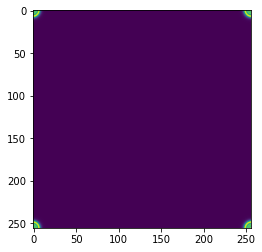

In [31]:

# train_loader = get_dataloaders(data_files=train_files,
#                                dataset=BlurryImageDatasetOnTheFlySweet,
#                                num_params=5,
#                                batch_size=4,
#                                shuffle=True,
#                                drop_last=False,
#                             params_filename="file_to_save_parm_psf")

i=0

# y, x_gt, k, kt = next(iter(train_loader))
# kj = shift(k[0].squeeze(0))

# plt.imshow(kj)

for y, x_gt, k, kt in tqdm(train_loader):
    plt.imshow(k[0].squeeze(0).cpu().numpy())
    print(np.shape(y),np.shape(x_gt))
#     kj = k[j].squeeze(0).cpu().numpy()
    i=i+1
    if i>10:
        break

In [19]:
#Get dataset ready!

#num_params for psf - fpr sweet project that makes psf 
num_params=5 # or 20 later! 

train_dataset = BlurryImageDatasetOnTheFlySweet(file_name_list=X_train,
                            is_rgb=False,
                            k_size=256,
                            max_num_images=None)

train_dataset.params_random_init(num_params)

#load data into batches, as aricle will do in batch of size(4) ! 
#article: https://arxiv.org/pdf/1804.03368.pdf

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)


# save_params(params_filename, files_dataset)


100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


In [10]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

#olya's way to shuffle again  
ids = np.random.permutation(len(test_files))
N = len(test_files) // 2

    valid_files = list(itemgetter(*ids[:N])(test_files))
    test_files = list(itemgetter(*ids[N:])(test_files))

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

IndentationError: unexpected indent (<ipython-input-10-33762a735c88>, line 11)

In [4]:
#Make our dataset old version
# from __future__ import print_function, absolute_import
import torch
import os
# import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from data.make_kernel import kernel_sim_spline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from pathlib import Path
# from operator import itemgetter
from skimage.color import rgb2gray
import pyDOE as doe # LHS
from scipy.stats.distributions import uniform
from tqdm import tqdm
# from skimage import util, filters
# from scipy import signal

from sweet.sweet import Sweet
from sweet.util.fft import shift, fft_conv


fixed_params = {
    'pupil_diam' : 2.5,
    'A' : 0
}

class BlurryImageDatasetOnTheFlySweet(Dataset):
    '''
    Implemented to use an eye's PSF from Sweet.
    PSF is not cropped.
    Convolution is perfomed with fft_conv.
    '''
    def __init__(self,
                 file_name_list,
                 is_rgb=True,
                 k_size=256,
                 patch_size=256,
                 max_num_images=None):
        assert is_rgb == False, 'RGB images currently not supported'
        
        self.file_name_list = sorted(file_name_list)
        self.is_rgb = is_rgb
        self.k_size = k_size
        self.patch_size = 256
        self.params = []
        self.num_params = 0

        if max_num_images is not None and max_num_images < len(
                self.file_name_list):
            self.file_name_list = self.file_name_list[:max_num_images]
        
    @staticmethod
    def get_psf(S, A, C, pupil_diam):
        sweet = Sweet()
        sweet.set_eye_prescription(
            S = S,  
            A = A,
            C = C,  
        )
        sweet.set_experiment_params(
            pupil_diam = pupil_diam,  
            view_dist = 100.0,      
            canvas_size_h = 10.0,  
        )
        psf = sweet._psf()
        return psf
    
    
    def params_init(self, params):
        self.params = params
        self.num_params = len(params)
      
        
    def params_random_init(self, num_params): #LHS      
        params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
        loc =   [-8, fixed_params['A'], -3, fixed_params['pupil_diam']]
        scale = [4,  fixed_params['A'],  3, fixed_params['pupil_diam']]
        for j in range(4):
            if j == 1:
                params[:, j] = fixed_params['A']
            elif j == 3:
                params[:, j] = fixed_params['pupil_diam']
            else:
                params[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(params[:, j])
        params = params.tolist()
        for i in tqdm(range(num_params)):
            psf = BlurryImageDatasetOnTheFlySweet.get_psf(*params[i])
            psf = psf / psf.sum()        ###### ADD NORMALIZING
            params[i].append(psf)   
        self.params = params
        self.num_params = num_params

        
    def __len__(self):
        return len(self.file_name_list)

    
    def __getitem__(self, idx):
        i = np.random.choice(np.arange(self.num_params))
        k = self.params[i][-1]
        img_name = self.file_name_list[idx]
        sample = plt.imread(img_name)

        if sample.shape[0] < self.patch_size or sample.shape[
                1] < self.patch_size:
            return self.__getitem__((idx - 1) % (self.__len__()))
        patches = image.extract_patches_2d(sample,
                                           [self.patch_size, self.patch_size],
                                           max_patches=1)
        sample = patches[0, ...]
        sample = sample.astype(np.float32) / 255.0
        if not self.is_rgb:
            sample = rgb2gray(sample)
        y = fft_conv(sample, k)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        
#         #adding noise nl
#         nl = np.random.uniform(0.003, 0.015)  #0.3% - 1.5%
#         y = y + nl * torch.randn_like(y)
        
        x_gt = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        k = torch.tensor(k, dtype=torch.float32).unsqueeze(0)
        kt = torch.flip(k, [1, 2])
        return y, x_gt, k, kt     
    